In [2]:
# Run in python console
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/habte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [4]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])


In [42]:
import pandas as pd
import glob

# Specify the path to the directory containing JSON files
directory_path = '/home/habte/Desktop/Anonymized_B6SlackExport_25Nov23/anonymized/all-community-building/'

# Use glob to get a list of all JSON files in the directory
json_files = glob.glob(directory_path + '/*.json')

# Initialize an empty list to store DataFrames
dfs = []

# Iterate through the list of JSON files and append them to the list
for file in json_files:
    dfs.append(pd.read_json(file))

# Concatenate the list of DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Now df contains the data from all JSON files in the directory
print(df.head())

      type       subtype            ts         user  \
0  message  channel_join  1.660301e+09  U03TEPYRM2P   
1  message  channel_join  1.660302e+09  U03T89ACUUW   
2  message           NaN  1.667908e+09  U03V1AM5TFA   
3  message           NaN  1.667909e+09  U03UG0YHAUT   
4  message           NaN  1.667910e+09  U03V1AM5TFA   

                                                text  \
0              <@U03TEPYRM2P> has joined the channel   
1              <@U03T89ACUUW> has joined the channel   
2  *community Building Session REMINDER!*:timer_c...   
3                                              Hello   
4  We are waiting for Guest Talk to finish, just ...   

                          client_msg_id  \
0                                   NaN   
1                                   NaN   
2  8baf2cd4-81e6-4d87-983b-29b0979ee0c4   
3  a0719222-17b2-41d7-8f93-e5a2db475658   
4  A67AD1D1-C4DC-46EF-8C19-7DA1F6654403   

                                              blocks         team  \
0   

In [43]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
ts,8302.0,1.664543e+09,2.066478e+06,1.660301e+09,1.662640e+09,1.664799e+09,1.665750e+09,1.669396e+09
thread_ts,4910.0,1.664658e+09,2.062557e+06,1.661169e+09,1.663072e+09,1.664799e+09,1.666268e+09,1.669393e+09
reply_count,1016.0,3.832677e+00,5.015400e+00,1.000000e+00,1.000000e+00,2.000000e+00,4.000000e+00,7.500000e+01
reply_users_count,1016.0,2.491142e+00,1.565616e+00,1.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,1.200000e+01
latest_reply,1016.0,1.664498e+09,2.057238e+06,1.661170e+09,1.662648e+09,1.664453e+09,1.665750e+09,1.669396e+09
is_locked,1016.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
subscribed,1016.0,1.377953e-02,1.166321e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
upload,651.0,3.072197e-03,5.538475e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
display_as_bot,595.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
last_read,14.0,1.664888e+09,2.775175e+06,1.661330e+09,1.661864e+09,1.665018e+09,1.667544e+09,1.668699e+09


In [44]:
print(df.columns)

Index(['type', 'subtype', 'ts', 'user', 'text', 'client_msg_id', 'blocks',
       'team', 'user_team', 'source_team', 'user_profile', 'edited',
       'thread_ts', 'reply_count', 'reply_users_count', 'latest_reply',
       'reply_users', 'replies', 'is_locked', 'subscribed', 'parent_user_id',
       'files', 'upload', 'display_as_bot', 'reactions', 'attachments', 'root',
       'last_read', 'channel', 'room', 'no_notifications', 'permalink',
       'bot_id', 'app_id', 'bot_profile', 'x_files', 'hidden'],
      dtype='object')


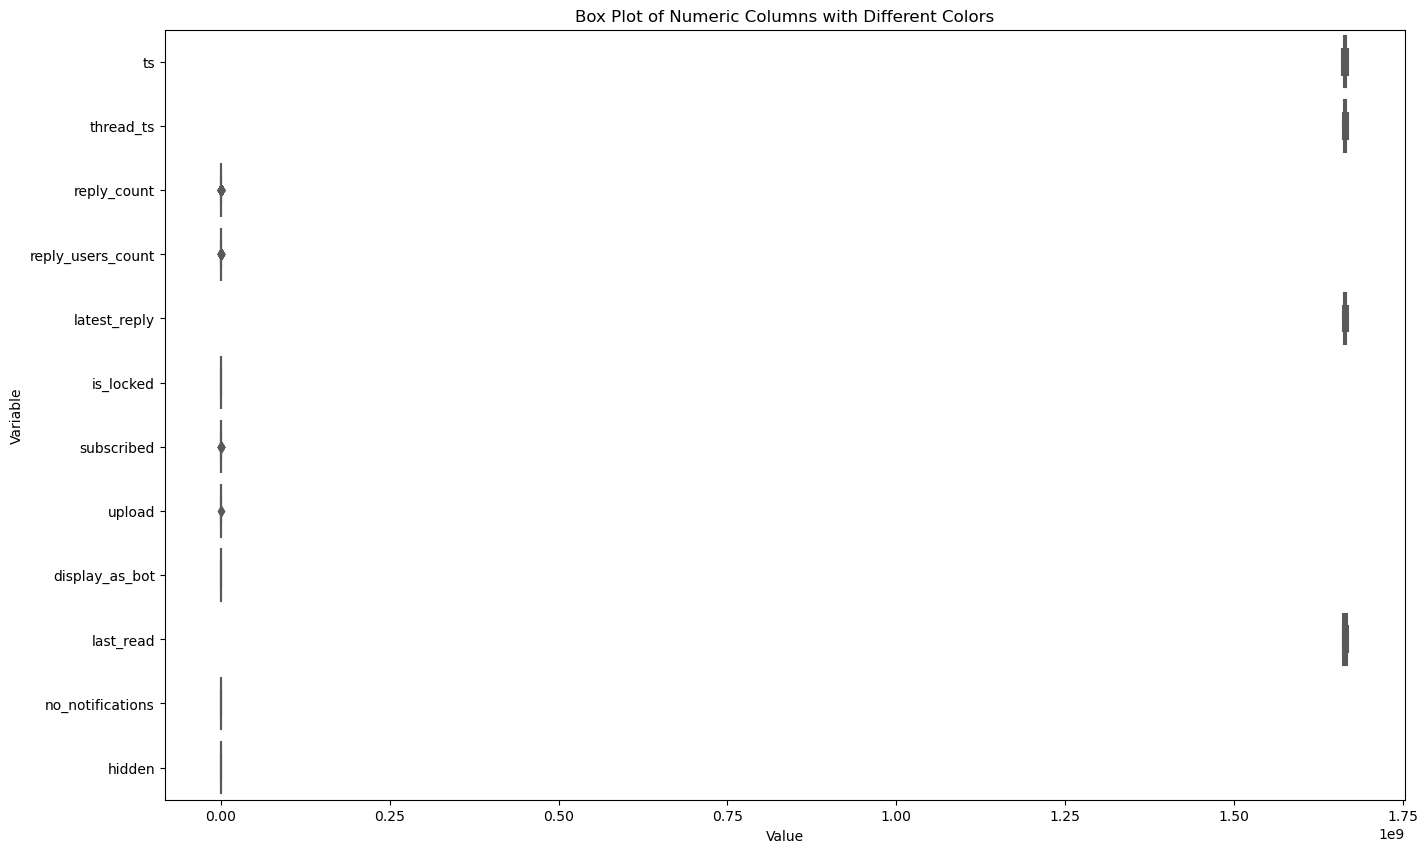

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Selecting only numeric columns for simplicity
numeric_columns = df.select_dtypes(include=['number'])

# Melt the DataFrame to long format
melted_df = pd.melt(numeric_columns, var_name="Variable", value_name="Value")

# Set the figure size
plt.figure(figsize=(16, 10))

# Create a box plot using Seaborn with different colors for each variable
sns.boxplot(x="Value", y="Variable", data=melted_df, palette="Set2")

# Set the title
plt.title('Box Plot of Numeric Columns with Different Colors')

# Show the plot
plt.show()


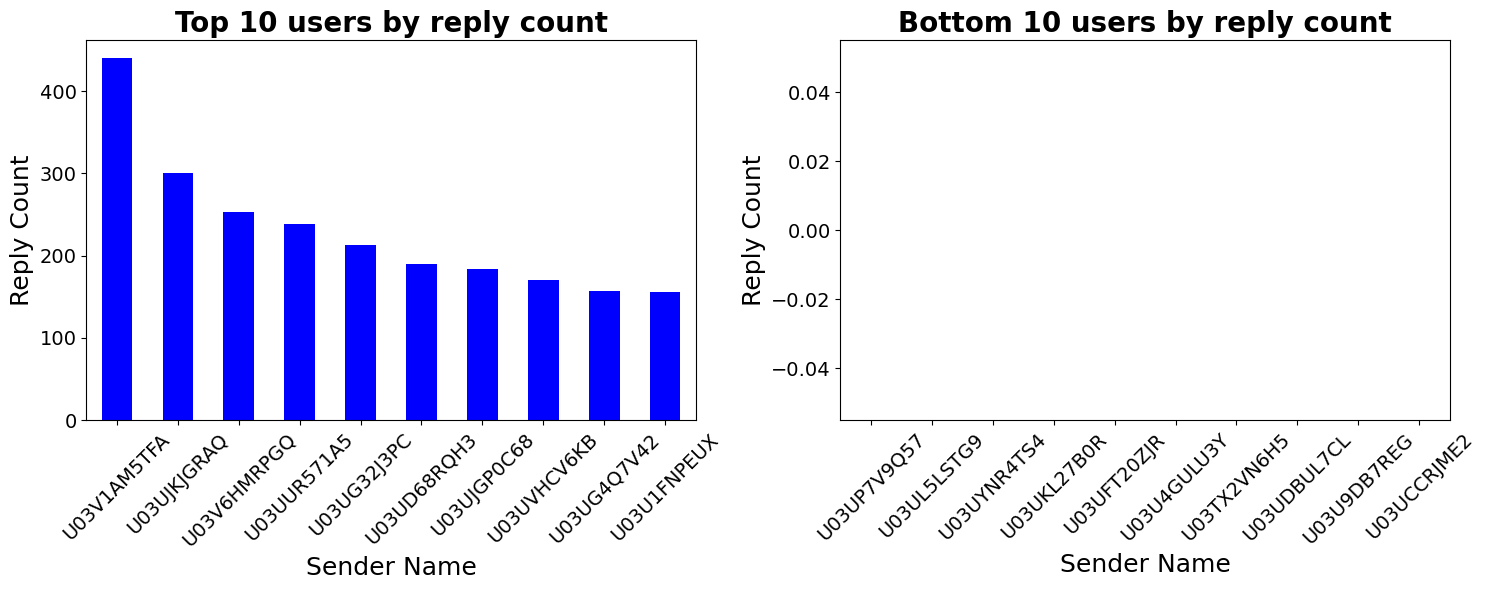

In [56]:
grouped_data = df.groupby('user')['reply_count'].sum()
top_10_users = grouped_data.sort_values(ascending=False)[:10]
bottom_10_users = grouped_data.sort_values(ascending=False)[-10:]

# Plotting the top 10 users
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
top_10_users.plot(kind='bar', color='blue')
plt.title('Top 10 users by reply count', size=20, fontweight='bold')
plt.xlabel("Sender Name", size=18)
plt.ylabel("Reply Count", size=18)
plt.xticks(rotation=45, size=14)
plt.yticks(size=14)
# Plotting the bottom 10 users
plt.subplot(1, 2, 2)
bottom_10_users.plot(kind='bar', color='red')
plt.title('Bottom 10 users by reply count', size=20, fontweight='bold')
plt.xlabel("Sender Name", size=18)
plt.ylabel("Reply Count", size=18)
plt.xticks(rotation=45, size=14)
plt.yticks(size=14)

plt.tight_layout()
plt.show()

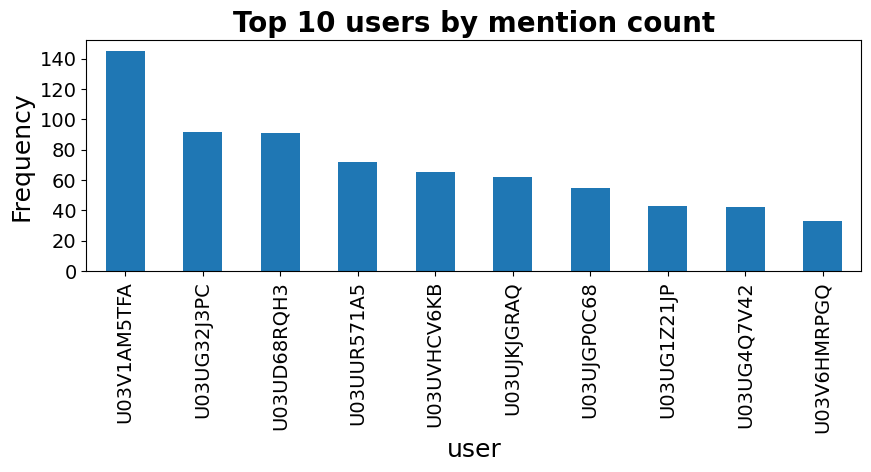

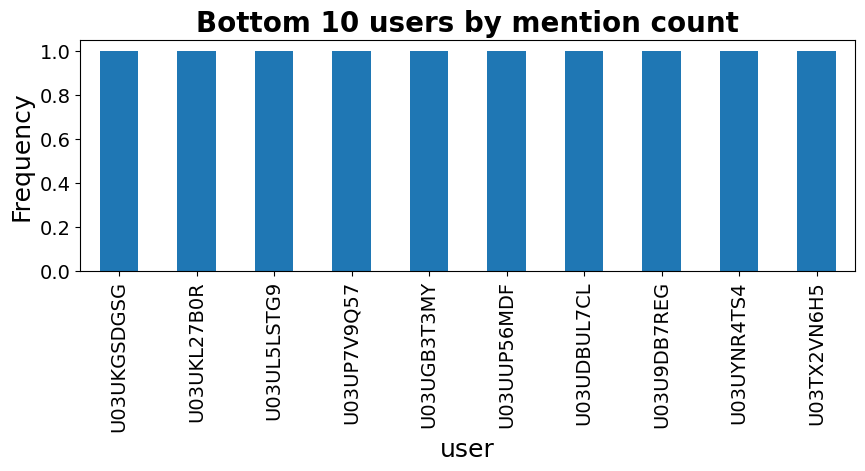

In [59]:
# Top 10 users by mention count
mention_counts = df[df['text'].str.contains('@U\w+')]
mention_counts.groupby('user')['text'].count().sort_values(ascending=False)[:10]\
    .plot(kind='bar', figsize=(10, 3))
plt.title('Top 10 users by mention count', size=20, fontweight='bold')
plt.xlabel("user", size=18)
plt.ylabel("Frequency", size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

# Bottom 10 users by mention count
mention_counts.groupby('user')['text'].count().sort_values(ascending=False)[-10:]\
    .plot(kind='bar', figsize=(10, 3))
plt.title('Bottom 10 users by mention count', size=20, fontweight='bold')
plt.xlabel("user", size=18)
plt.ylabel("Frequency", size=18)
plt.xticks(size=14)
plt.yticks(size=14)
plt.show()

In [60]:
#for the top 10 messages by replies
top = df.groupby('text')['reply_count'].sum().sort_values(ascending = False)[:10]
print('The top 10 messages by reply count are\n{}\n'.format(top))
#for bottom 10 messages by reply coount
bott = df.groupby('text')['reply_count'].sum().sort_values(ascending = False)[-10:]
print('The bottom 10 messages by reply count are\n{}\n'.format(bott))

The top 10 messages by reply count are
text
                                                                                                                                                                            211.0
<@U03V1AM5TFA> how many crushes you have?                                                                                                                                    75.0
First Impression: People think I am older than I am,\nWhy: My hairline                                                                                                       63.0
How many here follow football so much? I think it is almost everyone.                                                                                                        57.0
I want to ask my Ethiopian fellows about a pictur. It got me from the first time I saw it till now I feel connected to it and there is something thoughtfull behinds it      32.0
the debate was great. We <@U03U1J51VFZ>, <@U03UJGRN5E0> and I won 

In [46]:
df.shape

(8302, 37)

In [47]:
missing_values = df.isnull().sum()

In [48]:
missing_values

type                    0
subtype              8264
ts                      0
user                    0
text                    0
client_msg_id          46
blocks                204
team                  686
user_team             689
source_team           689
user_profile          689
edited               7864
thread_ts            3392
reply_count          7286
reply_users_count    7286
latest_reply         7286
reply_users          7286
replies              7286
is_locked            7286
subscribed           7286
parent_user_id       4422
files                7651
upload               7651
display_as_bot       7707
reactions            5882
attachments          8192
root                 8284
last_read            8288
channel              8300
room                 8300
no_notifications     8300
permalink            8300
bot_id               8299
app_id               8299
bot_profile          8299
x_files              8300
hidden               8301
dtype: int64

In [49]:
df_cleaned = df.dropna()

In [50]:
df_cleaned

,type,subtype,ts,user,text,client_msg_id,blocks,team,user_team,source_team,...,last_read,channel,room,no_notifications,permalink,bot_id,app_id,bot_profile,x_files,hidden


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8302 entries, 0 to 8301
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   type               8302 non-null   object 
 1   subtype            38 non-null     object 
 2   ts                 8302 non-null   float64
 3   user               8302 non-null   object 
 4   text               8302 non-null   object 
 5   client_msg_id      8256 non-null   object 
 6   blocks             8098 non-null   object 
 7   team               7616 non-null   object 
 8   user_team          7613 non-null   object 
 9   source_team        7613 non-null   object 
 10  user_profile       7613 non-null   object 
 11  edited             438 non-null    object 
 12  thread_ts          4910 non-null   float64
 13  reply_count        1016 non-null   float64
 14  reply_users_count  1016 non-null   float64
 15  latest_reply       1016 non-null   float64
 16  reply_users        1016 

In [52]:
import pandas as pd

# Calculate the total number of messages sent by each user
user_message_counts = df['user'].value_counts().reset_index(name='total_messages')

# Find the user with the highest total number of messages
user_with_highest_messages = user_message_counts.loc[user_message_counts['total_messages'].idxmax()]

print("User with the highest messages:")
print(user_with_highest_messages)


User with the highest messages:
user              U03V1AM5TFA
total_messages           1212
Name: 0, dtype: object


In [53]:
import pandas as pd
from textblob import TextBlob

# Perform sentiment analysis using TextBlob
df['sentiment'] = df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Categorize the sentiment into positive, negative, or neutral
df['sentiment_category'] = df['sentiment'].apply(lambda x: 'Positive' if x > 0 else ('Negative' if x < 0 else 'Neutral'))

# Display the DataFrame with sentiment information
print(df[['text', 'sentiment', 'sentiment_category']])


                                                   text  sentiment  \
0                 <@U03TEPYRM2P> has joined the channel   0.000000   
1                 <@U03T89ACUUW> has joined the channel   0.000000   
2     *community Building Session REMINDER!*:timer_c...   0.000000   
3                                                 Hello   0.000000   
4     We are waiting for Guest Talk to finish, just ...  -0.200000   
...                                                 ...        ...   
8297  An accident will happen before next week .. an...  -0.250000   
8298            So better submit it before the accident   0.500000   
8299  You can give it to your crush , remember it sh...   0.000000   
8300                                               Haha   0.200000   
8301  Did I say next week? I meant last week .. my p...  -0.133333   

     sentiment_category  
0               Neutral  
1               Neutral  
2               Neutral  
3               Neutral  
4              Negative  
...

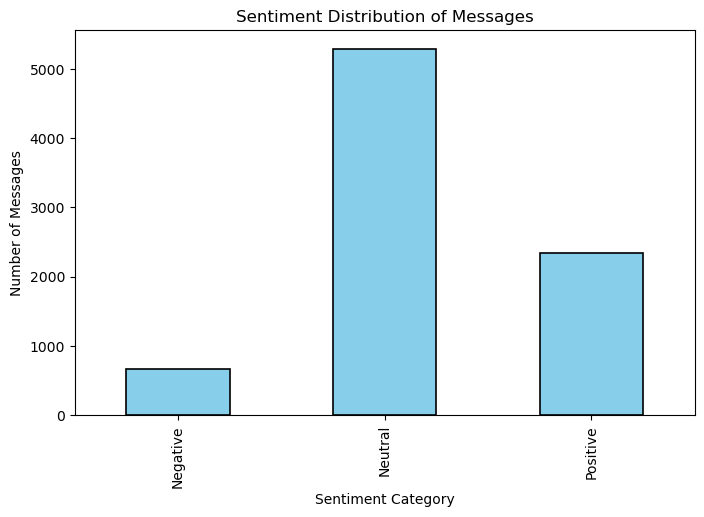

In [54]:
import matplotlib.pyplot as plt

# Plot sentiment distribution
plt.figure(figsize=(8, 5))
df['sentiment_category'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black', linewidth=1.2)
plt.title('Sentiment Distribution of Messages')
plt.xlabel('Sentiment Category')
plt.ylabel('Number of Messages')
plt.show()


In [16]:
# Calculate the proportion of messages in each sentiment category
sentiment_distribution = df['sentiment_category'].value_counts(normalize=True)

# Display the proportion of messages in each sentiment category
print(sentiment_distribution)


sentiment_category
Neutral     0.637678
Positive    0.282703
Negative    0.079619
Name: proportion, dtype: float64


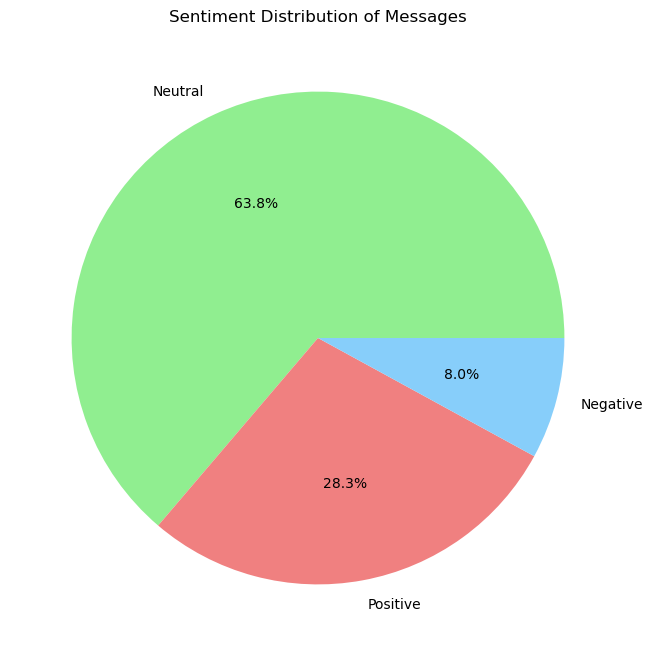

In [17]:
import matplotlib.pyplot as plt

# Plot pie chart for sentiment distribution
plt.figure(figsize=(8, 8))
sentiment_distribution.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightskyblue'])
plt.title('Sentiment Distribution of Messages')
plt.ylabel('')  # Remove y-axis label
plt.show()


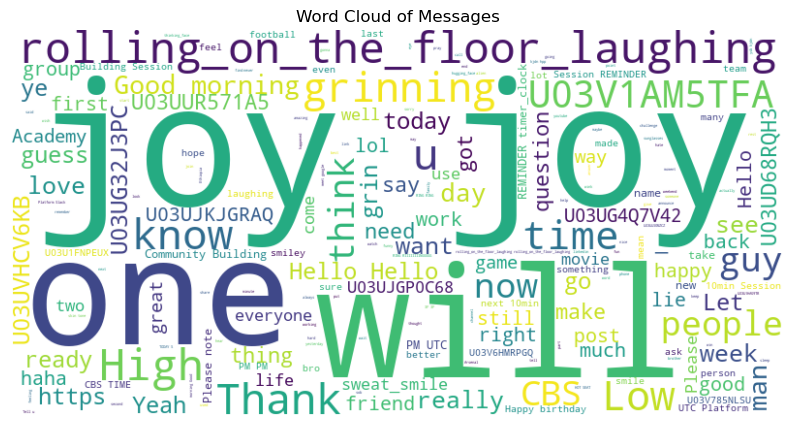

In [18]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all messages into a single string
all_text = ' '.join(df['text'].astype(str))

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Word Cloud of Messages')
plt.show()


Top 10 most common words:
the: 1775
I: 1691
to: 1359
you: 1101
is: 997
and: 960
a: 893
of: 680
for: 617
in: 577


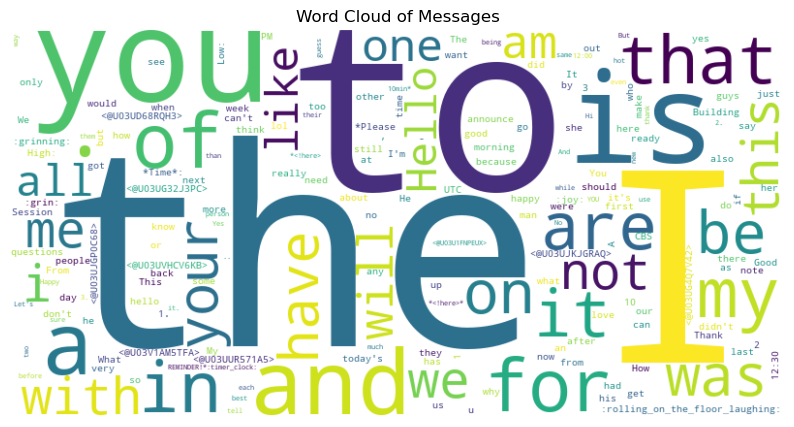

In [19]:
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Combine all messages into a single string
all_text = ' '.join(df['text'].astype(str))

# Tokenize the text into words
words = all_text.split()

# Use Counter to count the frequency of each word
word_counts = Counter(words)

# Display the top N most common words
top_words = word_counts.most_common(10)
print("Top 10 most common words:")
for word, count in top_words:
    print(f"{word}: {count}")

# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels
plt.title('Word Cloud of Messages')
plt.show()


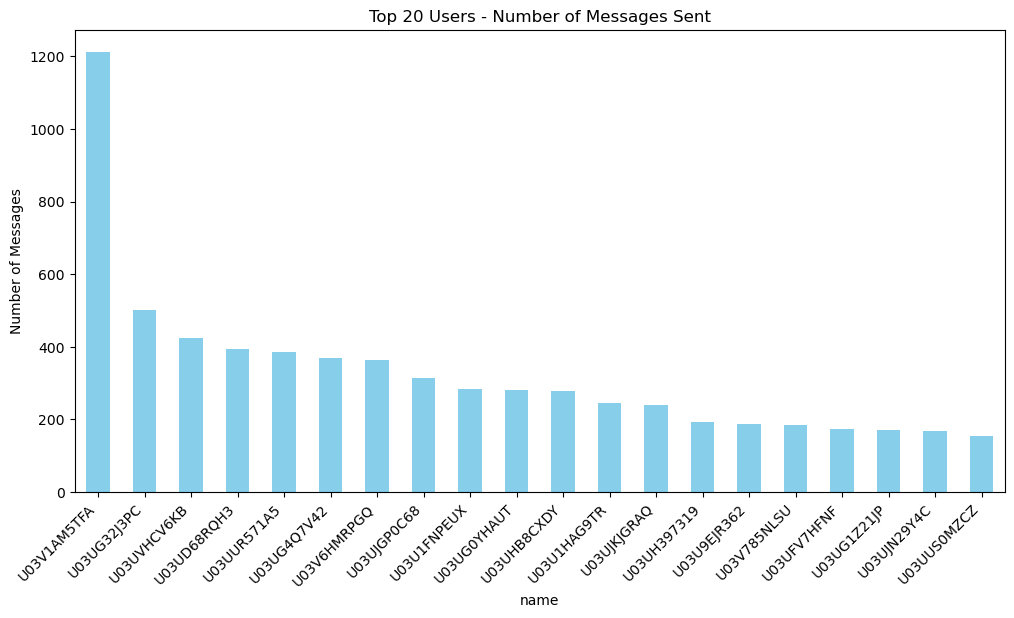

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

# Calculate the total number of messages sent by each user
user_message_counts = df['user'].value_counts()

# Select the top 20 users
top_20_users = user_message_counts.head(20)

# Plot histogram for the top 20 users
plt.figure(figsize=(12, 6))
top_20_users.plot(kind='bar', color='skyblue')
plt.title('Top 20 Users - Number of Messages Sent')
plt.xlabel('name')
plt.ylabel('Number of Messages')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()



In [22]:
# Find the index of the maximum reply_count
max_reply_index = df['reply_count'].idxmax()

print("Index of the maximum reply_count:", max_reply_index)


Index of the maximum reply_count: 1563


In [23]:
max_reply_count = df['reply_count'].max()
print("Maximum reply_count:", max_reply_count)


Maximum reply_count: 75.0


In [24]:
# Find the index of the maximum reply_count
max_reply_index = df['reply_count'].idxmax()

# Use the index to retrieve the user with the maximum reply_count
user_with_max_reply = df.loc[max_reply_index, 'user']

print("User with the maximum reply_count:", user_with_max_reply)


User with the maximum reply_count: U03UJKJGRAQ


In [92]:
# Sort the DataFrame by reply_count in descending order
sorted_df = df.sort_values(by='reply_count', ascending=False)

# Select the top 10 senders
top_10_senders = sorted_df.head(10)

# Display the result
print("Top 10 senders by maximum reply_count:")
print(top_10_senders[['user', 'reply_count']])


Top 10 senders by maximum reply_count:
             user  reply_count
1563  U03UJKJGRAQ         75.0
421   U03U1FQKEMV         63.0
3754  U03UJKJGRAQ         57.0
8106  U03UUR571A5         33.0
3105  U03V6HMRPGQ         32.0
7680  U03UJKJGRAQ         31.0
664   U03UUMR26Q1         27.0
7134  U03UUR571A5         25.0
6460  U03UD68RQH3         24.0
3416  U03V6HMRPGQ         24.0


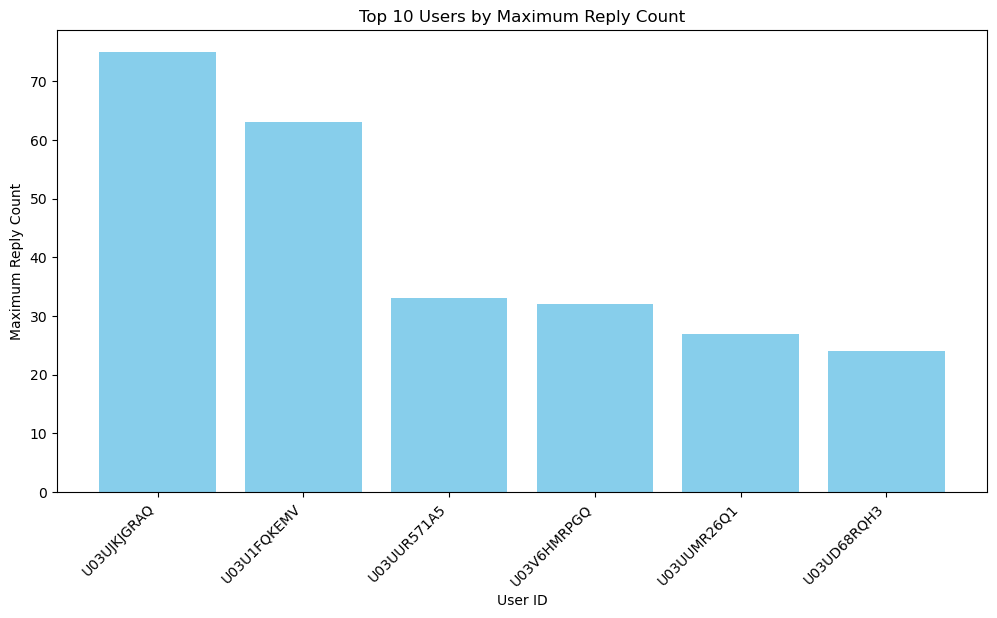

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

# Sort the DataFrame by reply_count in descending order
sorted_df = df.sort_values(by='reply_count', ascending=False)

# Select the top 10 senders
top_10_senders = sorted_df.head(10)

# Plot histogram for the top 10 senders
plt.figure(figsize=(12, 6))
plt.bar(top_10_senders['user'], top_10_senders['reply_count'], color='skyblue')
plt.title('Top 10 Users by Maximum Reply Count')
plt.xlabel('User ID')
plt.ylabel('Maximum Reply Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


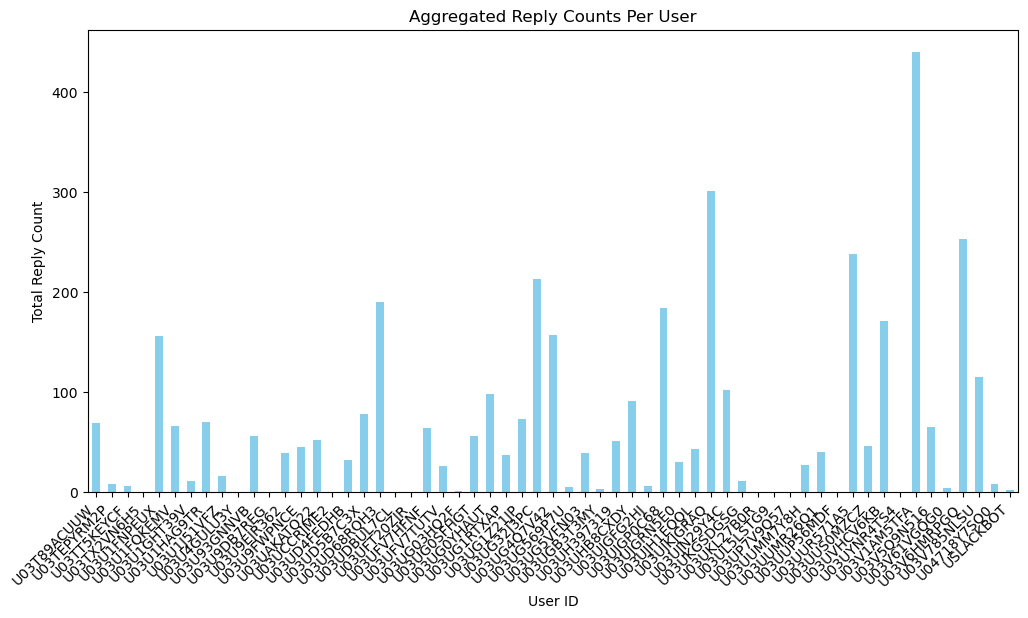

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by user and sum the reply_count
user_reply_counts = df.groupby('user')['reply_count'].sum()

# Plot histogram for aggregated reply counts per user
plt.figure(figsize=(12, 6))
user_reply_counts.plot(kind='bar', color='skyblue')
plt.title('Aggregated Reply Counts Per User')
plt.xlabel('User ID')
plt.ylabel('Total Reply Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()


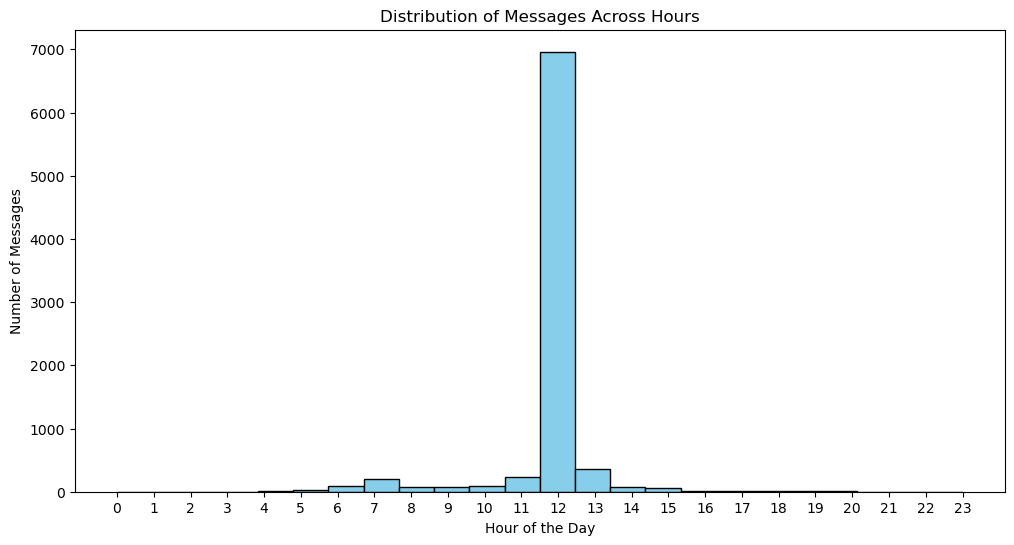

In [26]:

# Plot a histogram to visualize the distribution of messages across hours
import pandas as pd
import matplotlib.pyplot as plt

df['ts'] = pd.to_datetime(df['ts'], unit='s')

# Extract the hour from the timestamp
df['hour'] = df['ts'].dt.hour

# Plot histogram for the distribution of messages across hours
plt.figure(figsize=(12, 6))
plt.hist(df['hour'], bins=24, color='skyblue', edgecolor='black')
plt.title('Distribution of Messages Across Hours')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Messages')
plt.xticks(range(24))
plt.show()


In [27]:
import pandas as pd

# Convert timestamp to datetime
df['ts'] = pd.to_datetime(df['ts'], unit='s')

# Extract the hour from the timestamp
df['hour'] = df['ts'].dt.hour

# Group by hour and count the number of messages
hourly_message_counts = df['hour'].value_counts()

# Find the hour range with the highest message count
hour_with_highest_messages = hourly_message_counts.idxmax()

print("Hour range with the highest message count:", hour_with_highest_messages)


Hour range with the highest message count: 12


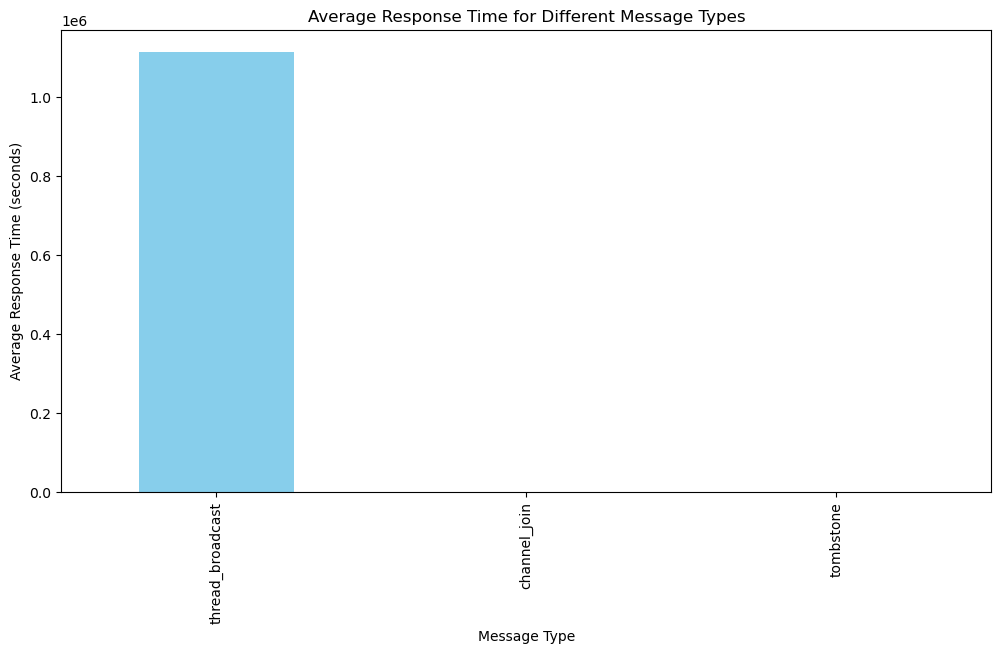

In [97]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert timestamp to datetime
df['ts'] = pd.to_datetime(df['ts'], unit='s')

# Sort DataFrame by timestamp
df = df.sort_values(by=['ts'])

# Calculate response time for each message
df['response_time'] = df.groupby(['user', 'subtype'])['ts'].diff()

# Convert response time to seconds for simplicity
df['response_time_seconds'] = df['response_time'].dt.total_seconds()

# Group by message subtype and calculate average response time
average_response_time = df.groupby('subtype')['response_time_seconds'].mean()

# Plot a bar chart
plt.figure(figsize=(12, 6))
average_response_time.sort_values(ascending=False).plot(kind='bar', color='skyblue')
plt.title('Average Response Time for Different Message Types')
plt.xlabel('Message Type')
plt.ylabel('Average Response Time (seconds)')
plt.show()

In [100]:
import pandas as pd

# Define functions to classify messages
def classify_message(text):
    # Check if the message contains keywords indicative of different categories
    if '?' in text:
        return 'Question'
    elif 'answer' in text.lower():
        return 'Answer'
    elif 'comment' in text.lower():
        return 'Comment'
    else:
        return 'Other'

# Apply the classification function to create a new column 'message_category'
df['message_category'] = df['text'].apply(classify_message)

# Display the result
print(df[['text', 'message_category']])


                                                   text message_category
0                 <@U03TEPYRM2P> has joined the channel            Other
1                 <@U03T89ACUUW> has joined the channel            Other
1736              <@U03U9DB7REG> has joined the channel            Other
1737              <@U03UKL27B0R> has joined the channel            Other
1738              <@U03UL5LSTG9> has joined the channel            Other
...                                                 ...              ...
6706                    <@U03T89ACUUW> is off this week            Other
6707                                        Okay thanks            Other
873   You all need this kind of Friend :rolling_on_t...            Other
874   We need someone who prays for us like this. BZ...            Other
875   <@U03UUR571A5> also told me that He is outsour...            Other

[8302 rows x 2 columns]


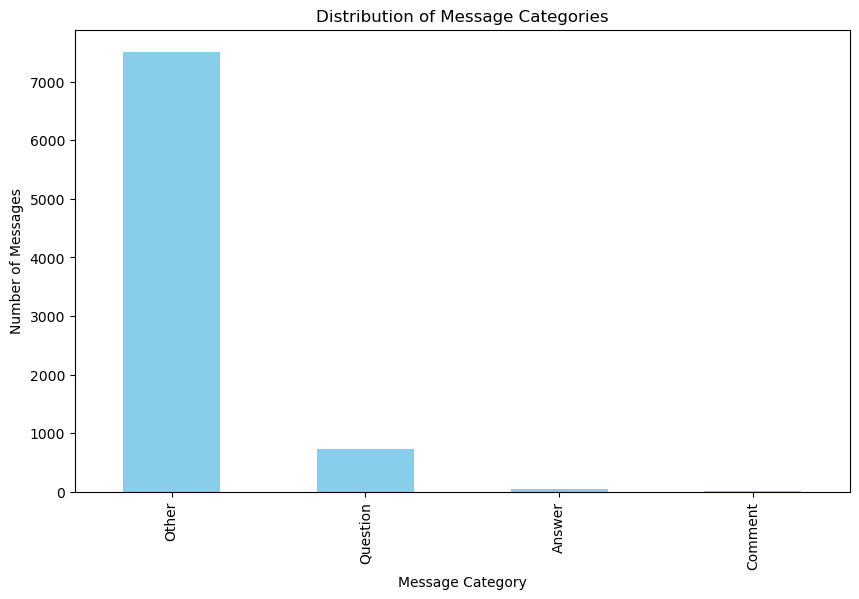

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Define functions to classify messages
def classify_message(text):
    if '?' in text:
        return 'Question'
    elif 'answer' in text.lower():
        return 'Answer'
    elif 'comment' in text.lower():
        return 'Comment'
    else:
        return 'Other'

# Apply the classification function to create a new column 'message_category'
df['message_category'] = df['text'].apply(classify_message)

# Plot histogram for message categories
plt.figure(figsize=(10, 6))
df['message_category'].value_counts().plot(kind='bar', color='skyblue')
plt.title('Distribution of Message Categories')
plt.xlabel('Message Category')
plt.ylabel('Number of Messages')
plt.show()


In [62]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

df['category'] = df['text'].apply(lambda x: 'message' if x == 'message' else 'non-message')

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['category'], test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer()
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train_tfidf, y_train)

# Make predictions
predictions = clf.predict(X_test_tfidf)

# Evaluate the model
print("Accuracy:", accuracy_score(y_test, predictions))
print(classification_report(y_test, predictions))

Accuracy: 1.0
              precision    recall  f1-score   support

 non-message       1.00      1.00      1.00      1661

    accuracy                           1.00      1661
   macro avg       1.00      1.00      1.00      1661
weighted avg       1.00      1.00      1.00      1661



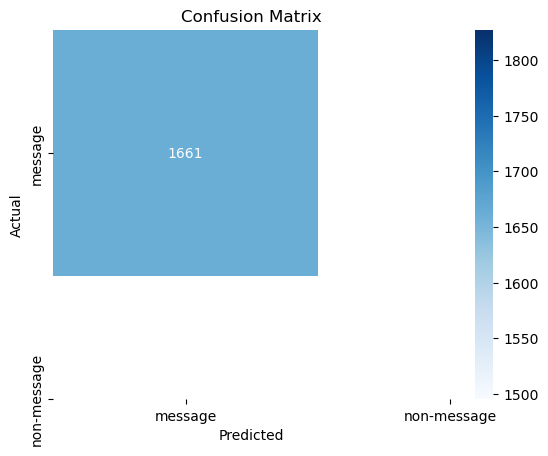

IndexError: index 1 is out of bounds for axis 1 with size 1

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion Matrix
conf_mat = confusion_matrix(y_test, predictions)
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['message', 'non-message'], yticklabels=['message', 'non-message'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve
y_probs = clf.predict_proba(X_test_tfidf)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test == 'message', y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


/home/habte/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_ranking.py:1123: UndefinedMetricWarning: No negative samples in y_true, false positive value should be meaningless
  warnings.warn(


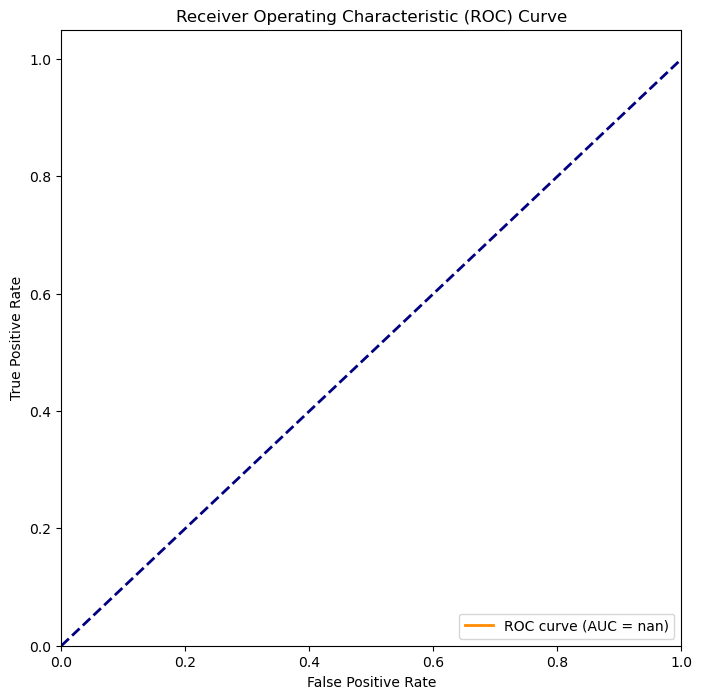

In [65]:
import numpy as np
from sklearn.preprocessing import label_binarize

# Convert labels to binary format
y_test_bin = label_binarize(y_test, classes=['message', 'non-message'])

# ROC Curve
y_probs = clf.predict_proba(X_test_tfidf)
fpr, tpr, _ = roc_curve(y_test_bin[:, 0], y_probs[:, 0])  # Assuming 'message' is the positive class
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

df1